In [59]:
# Import libraries
from __future__ import print_function
import numpy as np
import math
from math import ceil
import tensorflow as tf
import os   
import seaborn as sns
import matplotlib.pyplot as plt  # library for ploting math functions
import pandas as pd
import tensorflow.keras   # Import keras framework with various functions, models and structures
from tensorflow.keras.datasets import cifar10 # gets CIFAR-10 dataset from repository
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import pathlib
import shutil

# Set parameters for plots
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.2.0


## Data
Used dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#### Preparing the data

In [60]:
root_path = pathlib.Path('./chest_xray/chest_xray/') #directory for all images

In [108]:
train_data_dir = root_path / "train"
test_data_dir = root_path / "test"
val_data_dir = root_path / "val"

# def extractFiles(root_path, class_name): #extracting images
#     path = root_path / class_name
#     path.mkdir(parents=True, exist_ok=True)
#     path_filter = '*{0}*.jpeg'.format(class_name)
#     files = list((root_path / "PNEUMONIA").glob(path_filter))
#     for file in files:
#         shutil.move(str(file), root_path / class_name / file.name)
        
# def extractDataset(root_path): #
#     extractFiles(root_path, "virus")
#     extractFiles(root_path, "bacteria")
#     shutil.rmtree(root_path / "PNEUMONIA")

        
# extractDataset(train_data_dir)
# extractDataset(test_data_dir)
# extractDataset(val_data_dir)

In [62]:
train_image_count = len(list(train_data_dir.glob('*/*.jpeg')))
train_image_count

5216

In [63]:
test_image_count = len(list(test_data_dir.glob('*/*.jpeg')))
test_image_count

624

In [64]:
val_image_count = len(list(val_data_dir.glob('*/*.jpeg')))
val_image_count

16

### Extracting the class names from file names

In [65]:
class_names = np.array([item.name for item in train_data_dir.glob('*') if not item.name.startswith('.')]) 
num_classes = len(class_names)
class_names

array(['bacteria', 'NORMAL', 'virus'], dtype='<U8')

### Parameters setting

In [77]:
BATCH_SIZE = 32

def calc_steps_per_epoch(image_count):
    return np.ceil(image_count / BATCH_SIZE)

IMG_HEIGHT = 80
IMG_WIDTH = 80
TRAIN_STEPS_PER_EPOCH = calc_steps_per_epoch(train_image_count)
VAL_STEPS_PER_EPOCH = calc_steps_per_epoch(val_image_count)
TEST_STEPS_PER_EPOCH = calc_steps_per_epoch(test_image_count)
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

### Generating the train, test and validation data

In [78]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [79]:
train_data_gen = train_image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 5217 images belonging to 3 classes.


In [80]:
test_data_gen = image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))


Found 625 images belonging to 3 classes.


In [81]:
val_data_gen = image_generator.flow_from_directory(directory=str(val_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(class_names))

Found 18 images belonging to 3 classes.


### Displaying the sample train set

In [82]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(4, 8,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]==1][0].title())
      plt.axis('off')

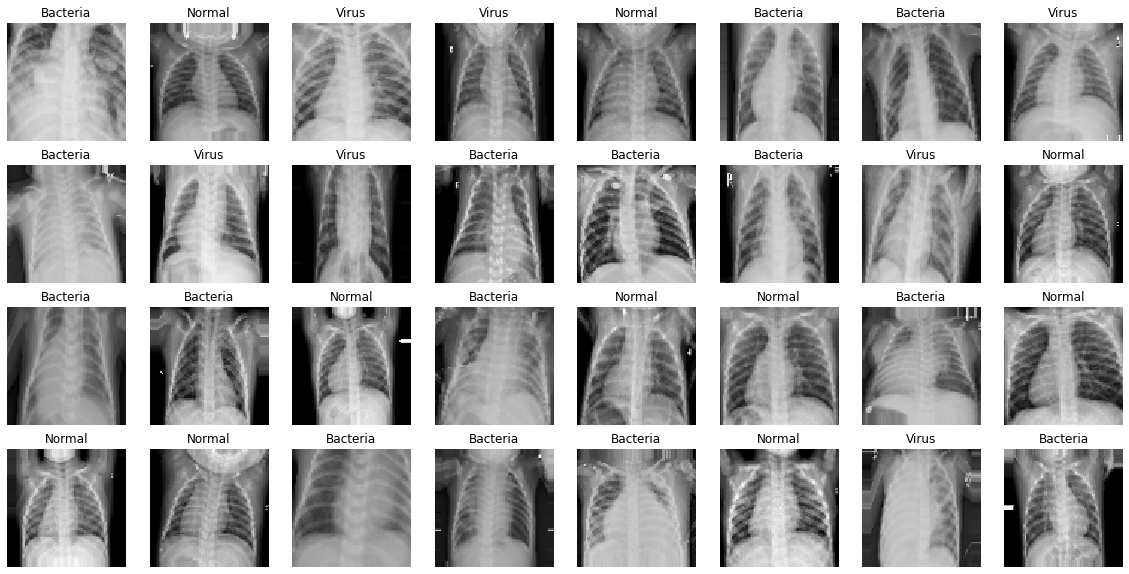

In [83]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Building a neural network structure (sequential model)

In [101]:
# Define the sequential Keras model composed of a few layers
model = Sequential()   # establishes the type of the network model
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dropout(0.25))
# model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
# model.add(Conv2D(32, (5, 5), activation='relu', padding='valid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
# model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [102]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

In [103]:
epochs = 30 # defining the number of epochs

history=model.fit_generator(train_data_gen,
                            epochs=epochs,
                            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,  # no of mini-batches 
                            validation_data=test_data_gen,
                            validation_steps=TEST_STEPS_PER_EPOCH,
                            verbose=1)

Epoch 1/30
163/163 [==============================] - 47s 286ms/step - loss: 0.9776 - acc: 0.5352 - val_loss: 0.7278 - val_acc: 0.6672
Epoch 2/30
163/163 [==============================] - 46s 282ms/step - loss: 0.7511 - acc: 0.6694 - val_loss: 0.6837 - val_acc: 0.6608
Epoch 3/30
163/163 [==============================] - 46s 280ms/step - loss: 0.7045 - acc: 0.6959 - val_loss: 0.6091 - val_acc: 0.7696
Epoch 4/30
163/163 [==============================] - 46s 283ms/step - loss: 0.6845 - acc: 0.7024 - val_loss: 0.6086 - val_acc: 0.8016
Epoch 5/30
163/163 [==============================] - 45s 278ms/step - loss: 0.6488 - acc: 0.7279 - val_loss: 0.5404 - val_acc: 0.8400
Epoch 6/30
163/163 [==============================] - 46s 283ms/step - loss: 0.6476 - acc: 0.7207 - val_loss: 0.6941 - val_acc: 0.7344
Epoch 7/30
163/163 [==============================] - 46s 283ms/step - loss: 0.6044 - acc: 0.7398 - val_loss: 0.5833 - val_acc: 0.8064
Epoch 8/30
163/163 [==============================] - 4

### Model evaluation

Test loss: 0.5388878583908081
Test accuracy: 0.8543999791145325


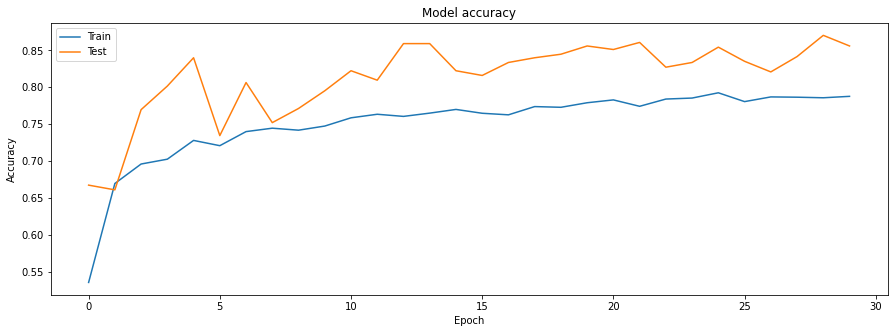

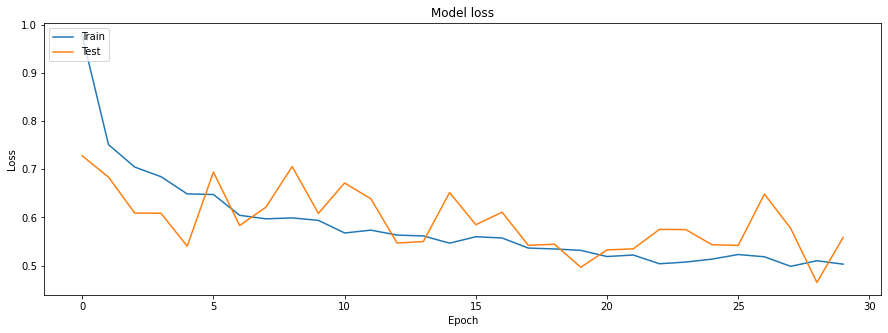

In [104]:
score = model.evaluate_generator(test_data_gen, verbose=0, steps=TEST_STEPS_PER_EPOCH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values: https://keras.io/visualization/#training-history-visualizatio
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')  # OR plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [105]:
test_data = np.array([data for batch in range(int(TEST_STEPS_PER_EPOCH)) for data in test_data_gen[batch][0]])
labels = [label for batch in range(int(TEST_STEPS_PER_EPOCH)) for label in np.argmax(test_data_gen[batch][1], axis=1)]

y_pred = model.predict(test_data)
y_pred_max = np.argmax(y_pred, axis=1)

### Generating the confusion matrix

Text(0.5, 105.0, 'Predicted label')

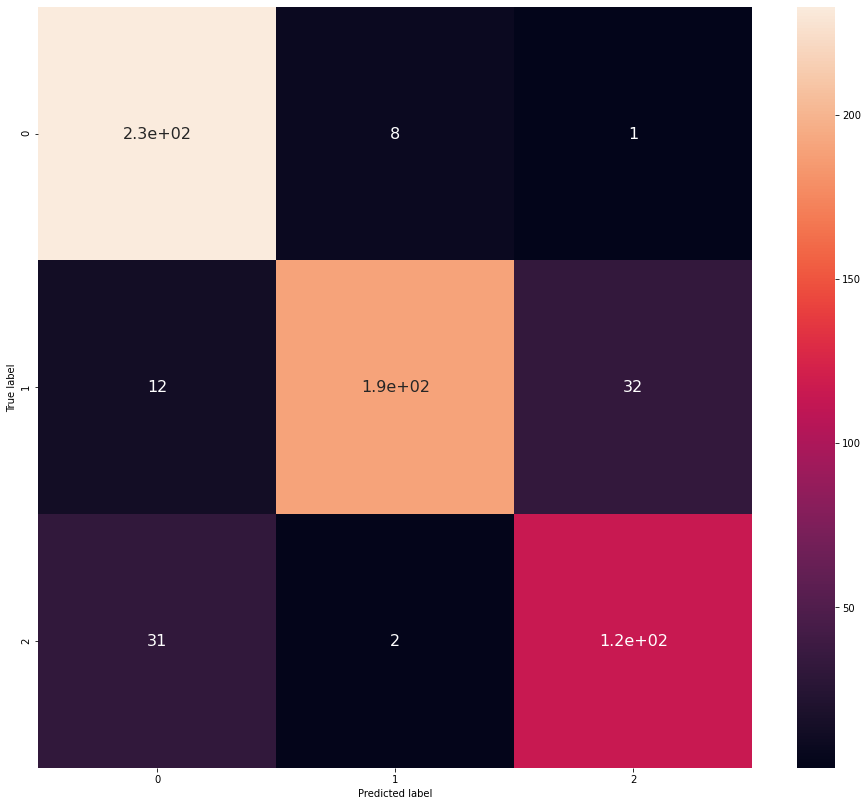

In [106]:
conf_mat = confusion_matrix(labels, y_pred_max)
conf_mat_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(16,14))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')